# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


regime data in construction


In [2]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=None, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

In [4]:
fwd = ['EUR1M CMPN Curncy', 'GBP1M CMPN Curncy', 'AUD1M CMPN Curncy', 
       'NZD1M CMPN Curncy', 'JPY1M CMPN Curncy', 'CAD1M CMPN Curncy', 
       'SEK1M CMPN Curncy', 'NOK1M CMPN Curncy', 'CHF1M CMPN Curncy']

fwd_scale_g10 = {"EURUSD": 10000,
                 "GBPUSD": 10000,
                 "AUDUSD": 10000,
                 "NZDUSD": 10000,
                 "USDJPY": 100,
                 "USDCAD": 10000,
                 "USDSEK": 10000,
                 "USDNOK": 10000,
                 "USDCHF": 10000}

fwd_data = new_raw_data[fwd].pipe(fill_date, fill_forward=True)
fwd_data.columns = fwd_scale_g10.keys()
for c in fwd_scale_g10.keys():
  fwd_data[c] = fwd_data[c]/fwd_scale_g10[c]
  
fwd_price_ori = spot_price_ori[fwd_scale_g10.keys()] + fwd_data

In [71]:
rx = fwd_price_ori.pipe(standardize_series, "prices").pipe(np.log10).shift(1) - \
    spot_price_ori[fwd_scale_g10.keys()].pipe(standardize_series, "prices").pipe(np.log10)

In [72]:
def rsv(x):
  mean = x.mean()
  rvu = sum([x**2 for x in x if x > mean])
  rvd = sum([x**2 for x in x if x <= mean])
  return rvu - rvd

In [73]:
rsv_signal = rx.groupby(rx.index.strftime('%Y-%m')).agg([rsv])
rsv_signal.columns = [x[0] for x in rsv_signal.columns]
rsv_signal.index = rx.loc[rx.groupby(rx.index.to_period('M')).apply(lambda x: x.index.max())].index

In [74]:
sig = rsv_signal.pipe(ranker_helper).pipe(fill_date, True)

In [75]:
def ranker(row, n=None):
  new_row = []
  indices = []
  for i,x in enumerate(row):
    if pd.notna(x):
      new_row.append(x)
    else:
      indices.append(i)

  if not n:
    n = max(len(new_row)//4, 1)

  order = np.argsort(new_row)
  for off in list(range(n,len(new_row)-n)):
    new_row[order[off]] = 0
  for j in range(n):
    new_row[order[j]] = 1
    new_row[order[(j+1)*-1]] = -1
    
  for i in indices:
    new_row.insert(i, np.nan)
  return pd.Series(new_row)
def ranker_helper(data, n=None):
  cols = data.columns
  new_data = data.apply(ranker, axis=1, n=n)
  new_data.columns = cols
  return new_data

# Signal

In [76]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [77]:
bt_obj = b

In [78]:
get_summary(bt_obj)

Returns   : 0.05095693128392629
Vol       : 0.1022450578667894
SR        : 0.4983803848036923
Max DD    : -26.96

C Returns : 0.04677956491482831
C SR      : 0.4144749836862462
C Max DD  : -24.25

Hit rate  : 0.522
W | N | L : 0.52 | 0.0 | 0.48
W/L Ratio : 1.09


In [61]:
get_returns_stats(bt_obj.asset_rtn.loc["2003":], b.wts.loc["2003":])

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,1.309981,-0.830356,-0.127053,0.684724,1.424175,1.666806,-0.017393,-0.554224,0.199212
sharpe,0.257221,-0.333144,-0.043749,0.19829,0.279253,0.30079,-0.0051,-0.163675,0.046951
dollar_sharpe,0.222886,-0.362177,-0.060429,0.179358,0.269015,0.24434,-0.023063,-0.179533,0.026838
trade_sharpe,0.370053,-0.635047,0.048071,0.2577,0.31809,0.286569,0.156026,-0.280877,0.143587
long_sharpe,-0.570957,-0.609099,-0.008737,0.251,0.38474,-0.994329,0.010736,0.34896,0.148872
short_sharpe,0.410074,-0.696192,0.474471,0.265812,-0.338,0.342165,0.883057,-0.658377,-0.247137
sortino,0.145356,-0.109888,-0.014138,0.072718,0.168434,0.196693,-0.002325,-0.068809,0.024547
max_drawdown,-12.101657,-15.899583,-16.167728,-9.394421,-13.901485,-16.030236,-10.806975,-21.966669,-12.642413
max_drawdown_start,2007-08-16,2003-01-01,2010-06-07,2009-12-29,2003-03-21,2014-07-09,2003-10-08,2003-05-29,2003-09-02
max_drawdown_end,2008-10-27,2015-03-17,2012-02-28,2011-07-29,2004-10-29,2015-10-01,2008-03-31,2014-11-18,2004-12-03


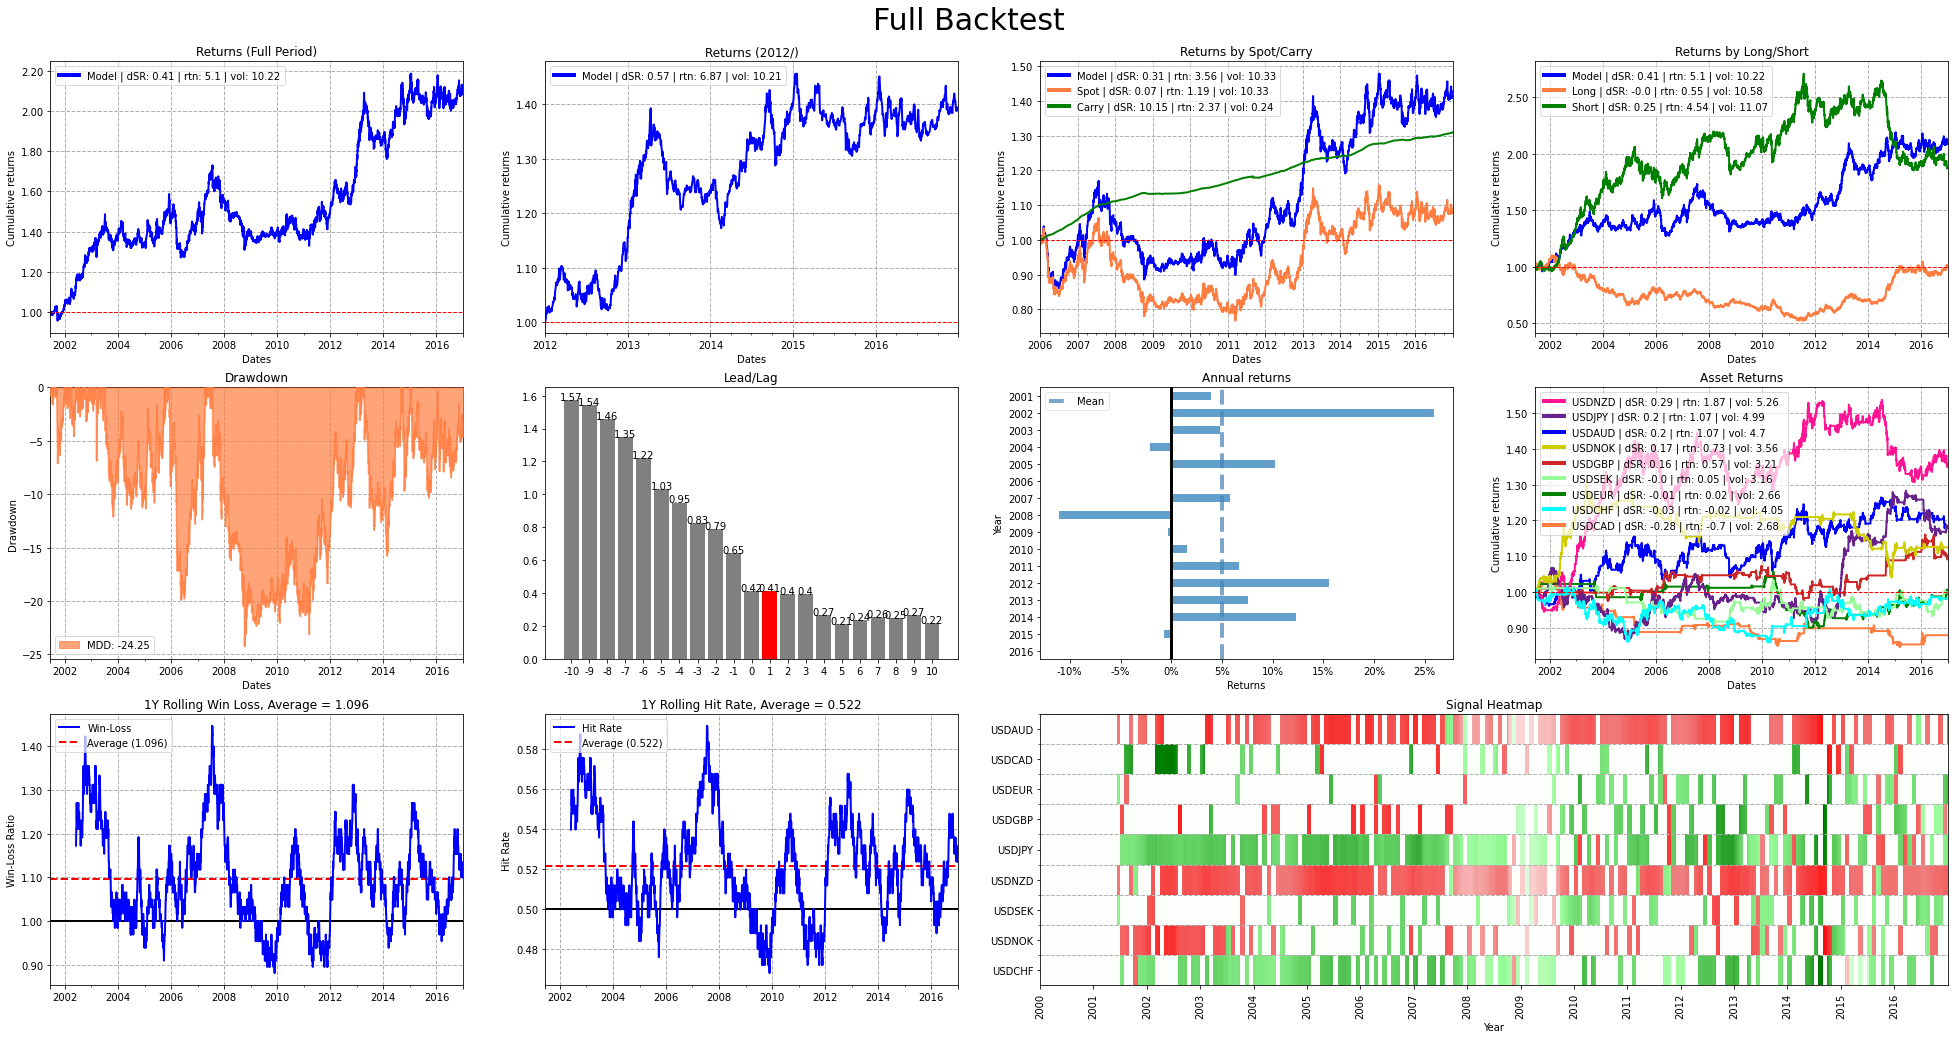

In [62]:
plot_bt(bt_obj)